## Artificial Neural Network

Logistic regression algoritması classification işlemi için iyidir fakat veri setinin karmaşıklığı arttığı zaman yeterli olmuyor ve başarımı belli bir seviyeye kadar çıkarabiliyoruz. Bunun için modelin karmaşıklığını non-linearity'isini arttırmalıyız. Bunu yapmak için de hidden layer'lar eklemeliyiz. Logistic regression'a neural network eklediğimiz zaman neural network algoritmasını elde etmeye başlıyoruz. Bu neural network algoritmasına artificial neural network diyeceğiz.

Bu kısımda Pytorch ile izlenecek adımlar şunlardır:

Steps of ANN:

    1-Import Libraries

    2-Prepare Dataset

    3-Create ANN Model

    4-Instantiate Model Class
    
    5-Instantiate Loss

    6-Instantiate Optimizer

    7-Traning the Model

    8-Prediction
    
Logistic regression dökümanında kullanılan veri setinin aynısı burada da kullanılacaktır.

In [3]:
# Import Libraries
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable  #Gradient hesabı yapacağımız için Variable'lere ihtiyaç vardır.
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Gradient hesabı yapılıp, bunlar accumulate edileceği için "from torch.autograd import Variable" satırı ile Variable tanımlanmıştır.

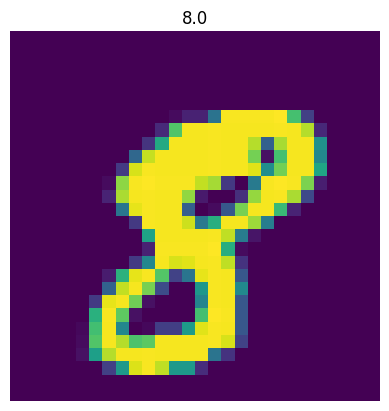

In [4]:
# Prepare Dataset
# load data
train = pd.read_csv(r"C:\Users\raziy\OneDrive\Masaüstü\Caner hocanın attıkları\KURS ÇALIŞMALARIM\Python ve Derin Öğrenme Pytorch ile Derin Öğrenme (5.3)\4-ArtificialNeuralNetworks\train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

<br>
<img src="a1.png" align = "left" style="width:700px;height:300px"/>

Yukarıdaki görselde bulunan yapı gerçekleştirilecektir. Şimdi bu yapıyı koda dökelim.

In [6]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    #Katmanları bağlama işlemi forward metodunun içerisinde yapılır.
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Softmax fonksiyonu CrossEntropyLoss()'un içerisinde bulunan bir fonksiyondur. Dolayısıyla aktivasyon fonksiyonlarının eklendiği kısımda softmax'ide eklemeye gerek yoktur.

Şimdi modeli train edelim.

In [7]:
# ANN model training
count = 0 #her 50 adımda bir loss ve accuracy değerleri print ettirilecek.
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7564125061035156  Accuracy: 78.53571319580078 %
Iteration: 1000  Loss: 0.466704785823822  Accuracy: 87.57142639160156 %
Iteration: 1500  Loss: 0.23960991203784943  Accuracy: 89.39286041259766 %
Iteration: 2000  Loss: 0.30487003922462463  Accuracy: 90.38095092773438 %
Iteration: 2500  Loss: 0.32812559604644775  Accuracy: 91.85713958740234 %
Iteration: 3000  Loss: 0.12364636361598969  Accuracy: 92.67857360839844 %
Iteration: 3500  Loss: 0.2268293797969818  Accuracy: 93.5 %
Iteration: 4000  Loss: 0.06601670384407043  Accuracy: 93.86904907226562 %
Iteration: 4500  Loss: 0.30926626920700073  Accuracy: 94.38095092773438 %
Iteration: 5000  Loss: 0.11355215311050415  Accuracy: 94.77381134033203 %
Iteration: 5500  Loss: 0.19294843077659607  Accuracy: 94.72618865966797 %
Iteration: 6000  Loss: 0.19791345298290253  Accuracy: 95.11904907226562 %
Iteration: 6500  Loss: 0.10405677556991577  Accuracy: 95.47618865966797 %
Iteration: 7000  Loss: 0.10874518752098083  Accuracy: 95

<br>
<img src="a2.png" align = "left" style="width:500px;height:200px"/>

Yukarıda gerçekleştirilenler görselde gördüğünüz gibidir. Prediction adımında üzerinde çarpı olan 2,4,5,6 adımları gerçekleştirilmemiştir, 1 ve 3. adımlar gerçekleştirilmiştir ve 7.adımda accuracy işlemi yapılmıştır.

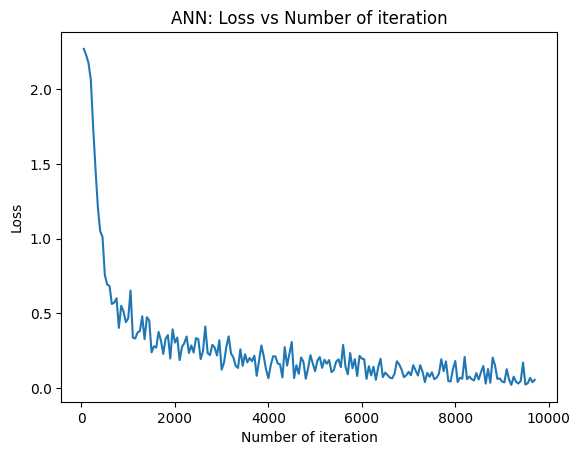

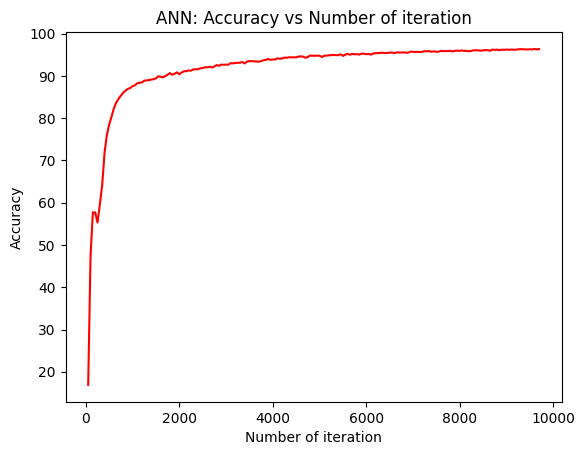

In [8]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()
